# 1. Load Libraries

In [188]:
import os
import warnings

import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing with minmax scaler
from sklearn.preprocessing import MinMaxScaler

# preprocessing with standard scaler
from sklearn.preprocessing import StandardScaler  # slightly better with standard scaler

# dealing with imbalanced dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

# feature selection
from sklearn.feature_selection import SelectKBest

# basic models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# ensemble models
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

# hyperparameter tuning bayesian optimization
from bayes_opt import BayesianOptimization
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import optuna
# for lgbm pruning (not used in v1)
from optuna.integration import LightGBMPruningCallback

# skopt tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# save tuned models
import joblib

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

We will make sure we have a directory where we will be able to save all the trained models, so that we can execute them later without having to wait that long. It is specially helpful for hyperparamter tuning, where we will select the best parameters found and save the model containing those.

In [12]:
if not os.path.isdir('models'):
    os.mkdir('models')

#### Load the dataset created in the EDA + FE notebook

In [13]:
with open('data/one-hot-encoded.pickle', 'rb') as file:
    dataset_dict = pickle.load(file)


dataset_dict.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

In [14]:
X_train = dataset_dict['X_train']
X_test = dataset_dict['X_test']
y_train = dataset_dict['y_train']
y_test = dataset_dict['y_test']

# 2. Feature Scaling

##### Execute One or the other, not both!!

In [15]:
# save column names and order
cols = X_train.columns

### 2.1 MinMaxScaler

In [6]:
# declare the scaler
scaler = MinMaxScaler()

# fit train and test data with the scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [7]:
# restore dataframes
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

### 2.2 StandardScaler

In [16]:
scaler = StandardScaler()

# fit train and test data with the scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [17]:
# restore dataframes
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

# 3. Multiple Model Testing

In this section, we will try plenty of models to see which one has the best performance. Then, we will optimize it, to see if we can get an even better classification. At the end, we will try to perform an ensemble of methods, where we will tune each model first, and then will try to put them all together to see if we can achieve greater performance. Finally, we will cross-validate our results so that our model is robust to out-of-bag observations.

## 3.1 Model Training without SMOTE

We will use several models, compare their performance, and based on that, we will move on to select which one to try to optimize.

The ones we will use are:
* LogisticRegression
* XGBoostClassifier
* LinearDiscriminantAnalysis
* AdaBoost
* CatBoost
* RandomForestClassifier
* SVM + KernelSVM
* MLP
* NaiveBayes
* SGDClassifier
* **Bonus**: Some Neural Net for TS classification (if time)

The **metric** we will use is the `F1-score`, since it will inform us about the precision and recall, which are going to be key for us. We are looking to predict when it will rain, so we don't want a classifier that predicts always _No_ or always _Yes_, or has a big bias towards a label, where the error for one is minmal, and in the other is about 50%.

In [23]:
num_folds = 10
seed = 743
scoring = 'roc_auc'
models = []
# basic models
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('SGD', SGDClassifier()))

# ensemble models
models.append(('XGB', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('ET', ExtraTreesClassifier()))

# KFolds for model selection:
results, names = [], []
for name, model in tqdm(models):
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("Model: {:>4} Mean: {:>8} Std: {:>8}".format(name, cv_results.mean(), cv_results.std()))

  8%|█████▊                                                               | 1/12 [00:08<01:34,  8.57s/it]

Model:   LR Mean: 0.870760117963618 Std: 0.0035602997511438553


 17%|███████████▌                                                         | 2/12 [00:19<01:39,  9.92s/it]

Model:  LDA Mean: 0.8678696104570222 Std: 0.003592664882054762


 25%|█████████████████▎                                                   | 3/12 [03:07<12:19, 82.19s/it]

Model:  KNN Mean: 0.760121583833479 Std: 0.006101850796215071


 33%|███████████████████████                                              | 4/12 [03:32<07:57, 59.72s/it]

Model: CART Mean: 0.6999305200892989 Std: 0.006213254791368686


 42%|████████████████████████████▊                                        | 5/12 [03:34<04:31, 38.81s/it]

Model:   NB Mean: 0.7395765727172489 Std: 0.006261520893702912


 50%|███████████████████████████████▌                               | 6/12 [2:36:23<5:14:19, 3143.17s/it]

Model:  SVM Mean: 0.8842631031615378 Std: 0.0033791878675583954


 58%|████████████████████████████████████▊                          | 7/12 [2:36:40<2:56:45, 2121.01s/it]

Model:  SGD Mean: 0.8554011061046761 Std: 0.005174131104921806


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████████████████████████████████████████                     | 8/12 [2:38:25<1:38:36, 1479.16s/it]

Model:  XGB Mean: 0.8925708579329117 Std: 0.002660893894633788


 75%|████████████████████████████████████████████████▊                | 9/12 [2:38:46<51:09, 1023.32s/it]

Model: LGBM Mean: 0.8882220793463314 Std: 0.0028248238308891415


 83%|██████████████████████████████████████████████████████▏          | 10/12 [2:42:11<25:41, 770.83s/it]

Model:   RF Mean: 0.8849565773879163 Std: 0.0026183030778087215


 92%|███████████████████████████████████████████████████████████▌     | 11/12 [2:43:35<09:20, 560.45s/it]

Model:  ADA Mean: 0.8625804754259864 Std: 0.00415634038977361


100%|█████████████████████████████████████████████████████████████████| 12/12 [2:47:13<00:00, 836.14s/it]

Model:   ET Mean: 0.8849689462673576 Std: 0.0035700156856877064


|Results| Time/it|
|---|---|
Model:   LR Mean: 0.870760117963618 Std: 0.0035602997511438553 | [00:08<01:34,  8.57s/it]
Model:  LDA Mean: 0.8678696104570222 Std: 0.003592664882054762 |[00:19<01:39,  9.92s/it]
Model:  KNN Mean: 0.760121583833479 Std: 0.006101850796215071 |[03:07<12:19, 82.19s/it]
Model: CART Mean: 0.6999305200892989 Std: 0.006213254791368686 | [03:32<07:57, 59.72s/it]
Model:   NB Mean: 0.7395765727172489 Std: 0.006261520893702912 |[03:34<04:31, 38.81s/it]
Model:  SVM Mean: 0.8842631031615378 Std: 0.0033791878675583954 |[2:36:23<5:14:19, 3143.17s/it]
Model:  SGD Mean: 0.8554011061046761 Std: 0.005174131104921806 | [2:36:40<2:56:45, 2121.01s/it]
Model:  XGB Mean: 0.8925708579329117 Std: 0.002660893894633788 | [2:38:25<1:38:36, 1479.16s/it]
Model: LGBM Mean: 0.8882220793463314 Std: 0.0028248238308891415 | [2:38:46<51:09, 1023.32s/it]
Model:   RF Mean: 0.8849565773879163 Std: 0.0026183030778087215 | [2:42:11<25:41, 770.83s/it]
Model:  ADA Mean: 0.8625804754259864 Std: 0.00415634038977361 | [2:43:35<09:20, 560.45s/it]
Model:   ET Mean: 0.8849689462673576 Std: 0.0035700156856877064 | [2:47:13<00:00, 836.14s/it]

The Best performing model was XGBoost with an average `AUC` of 89.25%, closely followed by LightGBM with an average`AUC`of 88.82%.

However, these are ensemble models _per se_, the best base model was the SVM model (88.4%), followed by the Logistic Regression (87.1%). Despite being the best performing basic model, was the slowest by far, taking about 3000s/it (50 minutes). Which in practice, meant about 3h due to the paralelization of folds.

## 3.2 Model Training with SMOTE

We define a pipeline for models where before compiling the model, we will generate new synthetic exammples of the minority class along the decision boundry between the two classes. For it, we will make use of the `Borderline-SMOTE` and we will get a 30% more of samples.

On the other hand, we will randomly undersample the majority class (augmenting too much the minority class could be conter-productive) and we will get a ration of 0.6 of the number of samples in the minority class over the number of samples in the majority class after resampling.

As a result, in this case, the proportion of $1$ in the `y_train` set goes from about a $22\%$ to almost a $38\%$.

In [28]:
over = SMOTE(sampling_strategy=0.3, k_neighbors=3)  # define frontier with the 3 nearest neighbors
under = RandomUnderSampler(sampling_strategy=0.6)

# Define Pipeline for 
pipeline = Pipeline(steps=[('over', over), ('under', under)
#                           , ('model', model)  # best performing model without SMOTE
                          ])

X_train_sm, y_train_sm = pipeline.fit_resample(X_train, y_train)
num_folds = 10
seed = 743
scoring = 'roc_auc'
# we will use the same models as before, so the models list does not change
# KFolds for model selection:
results_sm, names_sm = [], []
for name, model in tqdm(models):
    if name == 'SVM':
        kfold = KFold(n_splits=3, random_state=seed, shuffle=True)
    else:
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_sm, y_train_sm, cv=kfold, scoring=scoring)
    results_sm.append(cv_results)
    names_sm.append(name)
    print("Model: {:>4} Mean: {:>8} Std: {:>8}".format(name, cv_results.mean(), cv_results.std()))

  8%|█████▊                                                               | 1/12 [00:05<00:59,  5.39s/it]

Model:   LR Mean: 0.8710929625560008 Std: 0.006245787739367209


 17%|███████████▌                                                         | 2/12 [00:11<01:00,  6.04s/it]

Model:  LDA Mean: 0.8702037448547502 Std: 0.006151378833742926


 25%|█████████████████▎                                                   | 3/12 [01:07<04:18, 28.69s/it]

Model:  KNN Mean: 0.785841614134674 Std: 0.0061005132768899946


 33%|███████████████████████                                              | 4/12 [01:21<03:03, 22.92s/it]

Model: CART Mean: 0.7185718732423633 Std: 0.003874102105661948


 42%|████████████████████████████▊                                        | 5/12 [01:22<01:45, 15.01s/it]

Model:   NB Mean: 0.7390584293507192 Std: 0.0071413776531966695


 50%|██████████████████████████████████                                  | 6/12 [14:23<27:32, 275.34s/it]

Model:  SVM Mean: 0.8895017476335106 Std: 0.0015504667040328567


 58%|███████████████████████████████████████▋                            | 7/12 [14:36<15:47, 189.58s/it]

Model:  SGD Mean: 0.8577185253656168 Std: 0.00524000270897543
[14:37:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/david/anaconda3/envs/tf_uni/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|█████████████████████████████████████████████▎                      | 8/12 [15:40<09:58, 149.67s/it]

Model:  XGB Mean: 0.8928182495872251 Std: 0.006043725345170895


 75%|███████████████████████████████████████████████████                 | 9/12 [15:51<05:18, 106.25s/it]

Model: LGBM Mean: 0.8897791959284211 Std: 0.005587084883499769


 83%|███████████████████████████████████████████████████████▊           | 10/12 [17:52<03:41, 110.81s/it]

Model:   RF Mean: 0.8873399205429934 Std: 0.005527502069839781


 92%|██████████████████████████████████████████████████████████████▎     | 11/12 [18:38<01:31, 91.16s/it]

Model:  ADA Mean: 0.8631617769055419 Std: 0.005615097823674972


100%|███████████████████████████████████████████████████████████████████| 12/12 [20:49<00:00, 104.13s/it]

Model:   ET Mean: 0.8897262874404792 Std: 0.004439154904224929


|Results| Time/it|
|---|---|
Model:   LR Mean: 0.8710929625560008 Std: 0.006245787739367209 |  [00:05<00:59,  5.39s/it]
Model:  LDA Mean: 0.8702037448547502 Std: 0.006151378833742926 |  [00:11<01:00,  6.04s/it]
Model:  KNN Mean: 0.785841614134674 Std: 0.0061005132768899946 |  [01:07<04:18, 28.69s/it]
Model: CART Mean: 0.7185718732423633 Std: 0.003874102105661948 |  [01:21<03:03, 22.92s/it]
Model:   NB Mean: 0.7390584293507192 Std: 0.0071413776531966695 | [01:22<01:45, 15.01s/it]
Model:  SVM Mean: 0.8895017476335106 Std: 0.0015504667040328567 | [14:23<27:32, 275.34s/it]
Model:  SGD Mean: 0.8577185253656168 Std: 0.00524000270897543 |   [14:36<15:47, 189.58s/it]
Model:  XGB Mean: 0.8928182495872251 Std: 0.006043725345170895 |  [15:40<09:58, 149.67s/it]
Model: LGBM Mean: 0.8897791959284211 Std: 0.005587084883499769 |  [15:51<05:18, 106.25s/it]
Model:   RF Mean: 0.8873399205429934 Std: 0.005527502069839781 |  [17:52<03:41, 110.81s/it]
Model:  ADA Mean: 0.8631617769055419 Std: 0.005615097823674972 |  [18:38<01:31, 91.16s/it]
Model:   ET Mean: 0.8897262874404792 Std: 0.004439154904224929 |  [20:49<00:00, 104.13s/it]

We can see scores have improved a little bit in general, about a 1%. And training times have reduced drastically. Also, note that we have decreased the number of folds for the SVM, since otherwise, it takes too long and we already know it is the best performing algorithm of the basic ones.

#### Get an idea of which is the best number of neighbors to define the BorderlineSMOTE frontier

Let's try to optimize a little bit the number of neighbors for the BorderlineSMOTE using our best performing algorithm. 

In [39]:
model = XGBClassifier(use_label_encoder=False)

# create smote pipeline
k_values = [x for x in range(1, 11)]
for k in tqdm(k_values):
    over = BorderlineSMOTE(sampling_strategy=0.3, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.6)
#     pipeline = Pipeline(steps=[('over', over), ('under', under), ('model', model)])
    
    pipeline = Pipeline(steps=[('over', over), ('under', under)])
    X_train_smk, y_train_smk = pipeline.fit_resample(X_train, y_train)
    # evaluate pipeline
    cv = KFold(n_splits=10, random_state=743, shuffle=True)
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    scores = cross_val_score(model, X_train_smk, y_train_smk, scoring='roc_auc', cv=cv, n_jobs=-1)
    print(f'Mean ROC AUC: {np.mean(scores)}')

 10%|██████▊                                                             | 1/10 [04:02<36:21, 242.37s/it]

Mean ROC AUC: 0.8901940056891972


 20%|█████████████▌                                                      | 2/10 [08:07<32:34, 244.26s/it]

Mean ROC AUC: 0.8904078011072132


 30%|████████████████████▍                                               | 3/10 [12:12<28:31, 244.54s/it]

Mean ROC AUC: 0.8901256001297584


 40%|███████████████████████████▏                                        | 4/10 [16:31<25:00, 250.09s/it]

Mean ROC AUC: 0.8909211865028356


 50%|██████████████████████████████████                                  | 5/10 [20:36<20:40, 248.14s/it]

Mean ROC AUC: 0.8900894918007441


 60%|████████████████████████████████████████▊                           | 6/10 [24:34<16:19, 244.76s/it]

Mean ROC AUC: 0.8903707930640609


 70%|███████████████████████████████████████████████▌                    | 7/10 [28:42<12:17, 245.90s/it]

Mean ROC AUC: 0.8901049322789962


 80%|██████████████████████████████████████████████████████▍             | 8/10 [32:47<08:11, 245.66s/it]

Mean ROC AUC: 0.8905479412997126


 90%|█████████████████████████████████████████████████████████████▏      | 9/10 [36:43<04:02, 242.63s/it]

Mean ROC AUC: 0.8905827033210085


100%|███████████████████████████████████████████████████████████████████| 10/10 [40:40<00:00, 244.08s/it]

Mean ROC AUC: 0.8903041085586956


[15:21:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:17:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:16:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

After this small simulation, we get that, though there is not much difference, the best parameter for k is $4$.

If we look at our dataset right now, we can easily see there are more than a hundred different columns, which might make our models struggle with predictions. Let's try to find the bets number of features, so that it is both: as fast as possible and as accurate as possible.

### Save SMOTE dataset in our data directory

In [18]:
over = BorderlineSMOTE(sampling_strategy=0.3, k_neighbors=4)
under = RandomUnderSampler(sampling_strategy=0.6)   
pipeline = Pipeline(steps=[('over', over), ('under', under)])
X_train_smk, y_train_smk = pipeline.fit_resample(X_train, y_train)


We will save our dataset in a pickle file just in case we need to use it later in another file.

In [19]:
dataset_dict = {"X_train_smk": X_train_smk,
                "y_train_smk": y_train_smk}

with open('data/smote_knn.pickle', 'wb') as file:
    pickle.dump(dataset_dict, file)

# 4. Analyzing Features

# 4.1 Feature Importance

Let's get which have been the most important features the `XGBoostClassifier`has used to perform the best classification among all.

In [45]:
# initiate the classifier
xgb_clf = XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss')  # also eval:error


# fit the classifier with training SMOTE data
xgb_clf.fit(X_train_smk, y_train_smk)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [124]:
# https://stackoverflow.com/questions/40081888/xgboost-plot-importance-figure-size

# wrap function for plot_importance to add figsize to xgb.plot_importance
def xgb_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, **kwargs)

#### Weight Importance

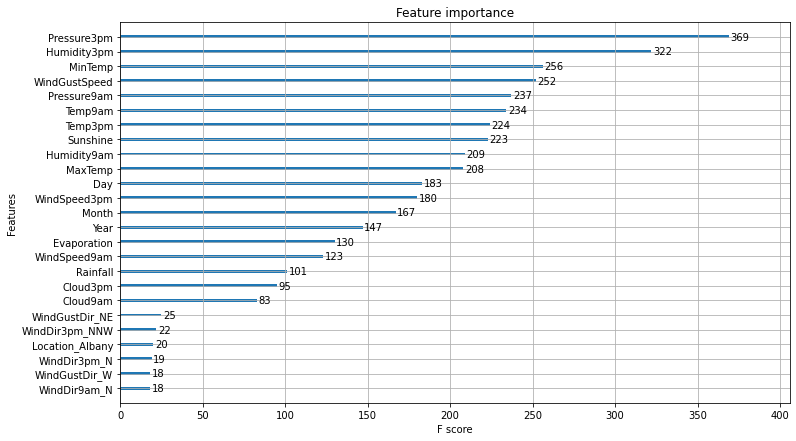

In [127]:
xgb_plot_importance(xgb_clf, figsize=(12, 7), max_num_features=25);

We can see that the most important features in this case are `Pressure` and `Humidity`, by a significant amount. This plot represents the weights our model has put on each parameter.

#### Accuracy Importance (gain)

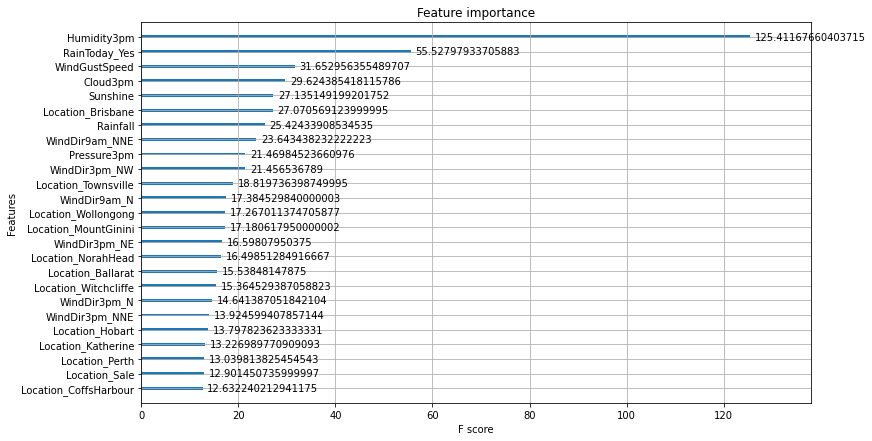

In [126]:
xgb_plot_importance(xgb_clf, figsize=(12, 7), max_num_features=25, importance_type='gain');

Now, location looks like it has much more relevance.

# 4.2 K-Best Features

We now know there are some features that contribute more to the prediction than others. As a result, some of the smaller variables might be adding noise to the output (maybe even some of the ones with high weight). Also, reducing the number of features, will help our algorithm avoid overfitting.

Hence, we will now look for the best combination of k-features, so that we don't have to use all the features that were given. The model will be faster and will have less tendency to overfit the data.

In [ ]:
model = XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss', verbose=1)  # also eval:error

fs = SelectKBest()  # f-classif by default
pipeline = Pipeline(steps=[('sel',fs), ('XGB', model)])
cv = KFold(n_splits=2, random_state=743, shuffle=True)

# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(1, X_train_smk.shape[1])]

# define the grid search
search = GridSearchCV(pipeline, grid, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=1)
# perform the search
results = search.fit(X_train_smk, y_train_smk)

# summarize best
print('Best AUC: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

# 5. Hyperparameter Tuning

From the model training with SMOTE, we got that the top 5 models were: `XGBoostClassifier`, `LGBMClassifier`, `RandomForestClassifier`, `ExtraTreesClassifier` and `SVM`.

We will use Bayesian Optimization for each of these models, so that we get the highest AUC possible in the cross-validation. Then, we will build an ensemble with these 5 models and another with the best XGBoost configurations. These will finally be evaluated with the test-set.

### Description of the Parts of the Optimization Process

https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

## XGBoost Tuning using Bayesian Optimization

### Define a cross-validation function for XGBoost Bayes optimization 

We will do that so that we avoid as much as possible overfitting

In [42]:
# Comment out any parameter you don't want to test
def XGB_CV(
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree,
          n_estimators        
         ):

    global AUCbest
    global ITERbest

#
# Define all XGboost parameters
#

    paramt = {
              'booster' : 'gbtree',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'eta' : 0.1,
              'objective' : 'binary:logistic',
              'n_estimators': int(n_estimators),
              'silent' : True,
              'eval_metric': 'auc',
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'seed' : 1001,
              'verbosity':0
              }
    folds = 5
    cv_score = 0
    print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
    log_file.flush()


    xgbc = xgb.cv(
                    paramt,
                    dtrain,
                    num_boost_round = 20000,
                    stratified = True,
                    nfold = folds,
                    verbose_eval = 0,
                    early_stopping_rounds = 100,
                    metrics = 'auc',
                    show_stdv = True
               )

    val_score = xgbc['test-auc-mean'].iloc[-1]
    train_score = xgbc['train-auc-mean'].iloc[-1]
    print(' Stopped after %d iterations with train-auc = %f val-auc = %f ( diff = %f ) train-gini = %f val-gini = %f' % ( len(xgbc), train_score, val_score, (train_score - val_score), (train_score*2-1), (val_score*2-1)) )
    if ( val_score > AUCbest ):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return (val_score*2) - 1


#### Create log-file, define xgb DMatrix and initialize performance params

In [43]:
# Create log-file
log_file = open('models/AUC-5fold-XGB-v1-full.log', 'a')

AUCbest = -1.
ITERbest = 0
dtrain = xgb.DMatrix(X_train_smk, label = y_train_smk)

#### Create Bayesian optimization object

In [44]:
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (2, 12),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (0, 20),
                                     'max_delta_step': (0, 10),
                                     'subsample': (0.4, 1.0),
                                     'colsample_bytree' :(0.4, 1.0),
                                     'n_estimators' : (80, 300)
                                    })

#### Define set of parameters you want the optimizer to explore

This will make our model experiment with more values than just the ones it thinks are best. Since it is informed search, not only will it get better with iterations, but we will be adding an extra layer where it can learn parameters from outside the region where it thinks the optimal values are. In this case, we define 8 different initial values for each of the params of interest.

In [45]:
params = {
          'max_depth':            [3, 8, 3, 8, 8, 3, 8, 3],
          'gamma':                [0.5, 8, 0.2, 9, 0.5, 8, 0.2, 9],
          'min_child_weight':     [0.2, 0.2, 0.2, 0.2, 12, 12, 12, 12],
          'max_delta_step':       [1, 2, 2, 1, 2, 1, 1, 2],
          'subsample':            [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
          'colsample_bytree':     [0.6, 0.8, 0.6, 0.8, 0.6, 0.8, 0.6, 0.8],
          'n_estimators' :        [100, 200, 100, 150, 200, 100, 150, 110]
        }

In [46]:
for i in range(8):
    XGB_BO.probe(
    params = [x[i] for x in params.values()],
    lazy=True,
)

#### Cross-validate the model for 50 iterations with 10 different initialization points

In [48]:
print('-'*130, file=log_file)
log_file.flush()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=10, n_iter=50, acq='ei', xi=0.0)  # v1

|   iter    |  target   | colsam... |   gamma   | max_de... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
 Stopped after 5436 iterations with train-auc = 0.883200 val-auc = 0.877526 ( diff = 0.005675 ) train-gini = 0.766401 val-gini = 0.755051
|  1        |  0.7551   |  3.0      |  0.5      |  0.2      |  1.0      |  0.6      |  0.6      |  100.0    |
 Stopped after 349 iterations with train-auc = 0.883958 val-auc = 0.878395 ( diff = 0.005563 ) train-gini = 0.767916 val-gini = 0.756790
|  2        |  0.7568   |  8.0      |  8.0      |  0.2      |  2.0      |  0.8      |  0.8      |  200.0    |
 Stopped after 4947 iterations with train-auc = 0.925884 val-auc = 0.895724 ( diff = 0.030160 ) train-gini = 0.851767 val-gini = 0.791448
|  3        |  0.7914   |  3.0      |  0.2      |  0.2      |  2.0      |  0.6      |  0.6      |  100.0    |
 Stopped after 649 iterations with tr

 Stopped after 1084 iterations with train-auc = 0.957523 val-auc = 0.899886 ( diff = 0.057637 ) train-gini = 0.915046 val-gini = 0.799772
|  26       |  0.7998   |  0.9085   |  4.439    |  1.098    |  5.567    |  4.767    |  113.7    |  0.7549   |
 Stopped after 2285 iterations with train-auc = 0.947516 val-auc = 0.897991 ( diff = 0.049525 ) train-gini = 0.895033 val-gini = 0.795982
|  27       |  0.796    |  0.7485   |  7.796    |  7.405    |  7.991    |  19.04    |  260.9    |  0.7463   |
 Stopped after 2930 iterations with train-auc = 0.939273 val-auc = 0.898716 ( diff = 0.040557 ) train-gini = 0.878546 val-gini = 0.797431
|  28       |  0.7974   |  0.8687   |  5.076    |  4.454    |  3.208    |  5.741    |  191.9    |  0.7      |
 Stopped after 687 iterations with train-auc = 0.956080 val-auc = 0.896751 ( diff = 0.059329 ) train-gini = 0.912159 val-gini = 0.793501
|  29       |  0.7935   |  0.7857   |  4.412    |  5.415    |  7.444    |  14.76    |  183.5    |  0.5468   |
 Stopped 

 Stopped after 1591 iterations with train-auc = 0.945435 val-auc = 0.898459 ( diff = 0.046975 ) train-gini = 0.890870 val-gini = 0.796919
|  52       |  0.7969   |  0.6939   |  4.04     |  7.21     |  4.046    |  11.74    |  291.4    |  0.8136   |
 Stopped after 553 iterations with train-auc = 0.961957 val-auc = 0.895831 ( diff = 0.066126 ) train-gini = 0.923914 val-gini = 0.791663
|  53       |  0.7917   |  0.7374   |  3.312    |  8.095    |  8.825    |  13.24    |  154.9    |  0.4474   |
 Stopped after 1236 iterations with train-auc = 0.957629 val-auc = 0.897767 ( diff = 0.059862 ) train-gini = 0.915257 val-gini = 0.795534
|  54       |  0.7955   |  0.7805   |  6.491    |  1.869    |  8.025    |  16.13    |  179.1    |  0.6886   |
 Stopped after 838 iterations with train-auc = 0.975637 val-auc = 0.898659 ( diff = 0.076979 ) train-gini = 0.951275 val-gini = 0.797318
|  55       |  0.7973   |  0.8646   |  0.5578   |  2.356    |  7.623    |  18.93    |  168.7    |  0.9045   |
 Stopped a

#### Write results in log-file

In [56]:
# write final results
print('-'*130)
print('Final Results')
print('Maximum XGBOOST value: %f' % XGB_BO.max['target'])
print('Best XGBOOST parameters: ', XGB_BO.max['params'])
print('-'*130, file=log_file)
print('Final Result:', file=log_file)
print('Maximum XGBOOST value: %f' % XGB_BO.max['target'], file=log_file)
print('Best XGBOOST parameters: ', XGB_BO.max['params'], file=log_file)
log_file.flush()
log_file.close()


----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum XGBOOST value: 0.801024
Best XGBOOST parameters:  {'colsample_bytree': 0.7095602946940276, 'gamma': 1.873867984841, 'max_delta_step': 7.589837888907509, 'max_depth': 10.310480243860749, 'min_child_weight': 4.305083126324996, 'n_estimators': 275.68683201533815, 'subsample': 0.8426619588600843}


In [74]:
history_df = pd.DataFrame(XGB_BO.res)
history_df.rename(columns={'target':'gini'}, inplace=True)
history_df['AUC'] = (history_df['gini'] + 1)/2
history_df.to_csv('models/AUC-5fold-XGB-v1-full.csv')

In [75]:
history_df

,gini,params,AUC
0,0.755051,"{'colsample_bytree': 3.0, 'gamma': 0.5, 'max_d...",0.877526
1,0.756790,"{'colsample_bytree': 8.0, 'gamma': 8.0, 'max_d...",0.878395
2,0.791448,"{'colsample_bytree': 3.0, 'gamma': 0.2, 'max_d...",0.895724
3,0.743054,"{'colsample_bytree': 8.0, 'gamma': 9.0, 'max_d...",0.871527
4,0.788582,"{'colsample_bytree': 8.0, 'gamma': 0.5, 'max_d...",0.894291
...,...,...,...
63,0.800258,"{'colsample_bytree': 0.8496765659282681, 'gamm...",0.900129
64,0.794267,"{'colsample_bytree': 0.561370873981323, 'gamma...",0.897133
65,0.801024,"{'colsample_bytree': 0.7095602946940276, 'gamm...",0.900512
66,0.792714,"{'colsample_bytree': 0.7537236674370227, 'gamm...",0.896357


#### View the best params

In [113]:
xgb_params = XGB_BO.max['params']

print(xgb_params)

#Converting the max_depth and n_estimator values from float to int
xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['n_estimators'] = int(xgb_params['n_estimators'])

{'colsample_bytree': 0.7095602946940276, 'gamma': 1.873867984841, 'max_delta_step': 7.589837888907509, 'max_depth': 10.310480243860749, 'min_child_weight': 4.305083126324996, 'n_estimators': 275.68683201533815, 'subsample': 0.8426619588600843}


In [112]:
from xgboost import XGBClassifier
xgb_opt = XGBClassifier(**xgb_params)
xgb_opt.set_params(use_label_encoder=False)

kfold = KFold(n_splits=10, random_state=743, shuffle=True)
cv_results = cross_val_score(xgb_opt, X_train_smk, y_train_smk, cv=kfold, scoring='roc_auc')
print("XGB_opt Mean: {:>8} Std: {:>8}".format(cv_results.mean(), cv_results.std()))

XGB_opt Mean: 0.8930242511713622 Std: 0.0032293766311479303


We will test it with the test-set in the last section of the notebook, so that we don't backtest overfit our model.

### Save model in `models` folder

In [115]:
joblib.dump(xgb_opt, 'models/XGB_BAYES_OPT.pkl')

['models/XGB_BAYES_OPT.pkl']

In [117]:
xgb_bayes_opt = joblib.load('models/XGB_BAYES_OPT.pkl')

In [118]:
xgb_bayes_opt

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.7095602946940276,
              eval_metric='logloss', gamma=1.873867984841, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=7.589837888907509,
              max_depth=10, min_child_weight=4.305083126324996, missing=nan,
              monotone_constraints=None, n_estimators=275, n_jobs=None,
              num_parallel_tree=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None,
              subsample=0.8426619588600843, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)

## LightGBM Optimization using Bayesian Optimization

For Bayesian Optimization optuna can also be used: `!pip install optuna`.

That library uses a bayesian optimization algorithm called **Tree-structured Parzen Estimator**.

It is recommended for LGBM.

# LGBM Optimization with OPTUNA

Credits to: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

Optuna employs a Bayesian optimization algorithm called **Tree-structured Parzen Estimator**

#### Define function and grid of parameters to optimize

In [346]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "metric" : "auc"
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid, verbosity=-1)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            early_stopping_rounds=100,
            verbose=-1
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:, 1])

    return np.mean(cv_scores)

#### Search the best hyperparameters

In [347]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
    func = lambda trial: objective(trial, X_train_smk, y_train_smk)
    study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8551405864567552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8551405864567552
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=11.818389018092455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.818389018092455
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=12.519565975391034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.519565975391034
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.439850100056446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.439850100056446
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Wa

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.06708934985206, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.06708934985206
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current val

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.4684296286133294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4684296286133294
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.2631637946185508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2631637946185508
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=14.787595864454708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.787595864454708
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.0264889609243872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0264889609243872
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.9832992755189722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9832992755189722
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.469531979133373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.469531979133373
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.1890889062913432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.1890889062913432
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.2103716344082526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2103716344082526
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Cu

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.9348202843848163, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9348202843848163
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.051445608334745, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.051445608334745
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.08300862555008734, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08300862555008734
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.2488224386517333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2488224386517333
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.08802731776568995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08802731776568995
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=4.736166411092871, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.736166411092871
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=10.086582147229914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.086582147229914
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.5026438083479765, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5026438083479765
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.004904000626194029, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004904000626194029
[LightGBM] [Warning] min_data_in_leaf is set=5400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5400
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.006667484031903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.006667484031903
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.60000

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=6.656371891023057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.656371891023057
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subs

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.022294378011100693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022294378011100693
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.719846033901183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.719846033901183
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.685075410530624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.685075410530624
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4912850770171562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4912850770171562
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7607270367432676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7607270367432676
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.00516556696857065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00516556696857065
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.8842115311430514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8842115311430514
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.4945514236897362, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4945514236897362
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3874781674137846, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3874781674137846
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.5919083246845248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5919083246845248
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.055262834448886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.055262834448886
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subs

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.4987981912653753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4987981912653753
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, 

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.4937104225202715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4937104225202715
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.9158147389342438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9158147389342438
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.012548560662734402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012548560662734402
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.6337465556892816, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6337465556892816
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=2.6431036078986496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6431036078986496
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.4810554192062412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4810554192062412
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7598862782518306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7598862782518306
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.7740559724352709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7740559724352709
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8126196270148466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8126196270148466
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.8664561052563051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8664561052563051
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Wa

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.6936418167610039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6936418167610039
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, su

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=9.563622763242115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.563622763242115
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsam

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.3758122083037176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3758122083037176
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.39826191082045725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.39826191082045725
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subs

In [358]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")


	Best value (auc): 0.89443
	Best params:
		n_estimators: 10000
		learning_rate: 0.17522338789351122
		num_leaves: 1860
		max_depth: 8
		min_data_in_leaf: 300
		lambda_l1: 5
		lambda_l2: 0
		min_gain_to_split: 0.3679620526888811
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.6000000000000001


Which, if we calculate our KFoldCV , gives us:

In [349]:
lgb_params_optuna = study.best_params

In [350]:
from lightgbm import LGBMClassifier
lgbm_opt = LGBMClassifier(**lgb_params_optuna)
lgbm_opt.set_params(verbosity=-1)

kfold = KFold(n_splits=10, random_state=743, shuffle=True)
cv_results = cross_val_score(lgbm_opt, X_train_smk, y_train_smk, cv=kfold, scoring='roc_auc')

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.3679620526888811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3679620526888811
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000

In [351]:
print("LGBM_opt Mean: {:>8} Std: {:>8}".format(cv_results.mean(), cv_results.std()))

LGBM_opt Mean: 0.8921414276154065 Std: 0.004040498546200701


Quite better than without parameter optimization. It is now pretty close to XGBoost optimized with the bayesian. We could probably get a better AUC with more trials. 

### Save LGBM_OPTUNA study model in `models` folder

In [362]:
joblib.dump(study, 'models/LGBM_OPTUNA_v1_study.pkl')

['models/LGBM_OPTUNA_v1_study.pkl']

In [395]:
mystudy = joblib.load('models/LGBM_OPTUNA_v1_study.pkl')

In [396]:
mystudy.best_trials

[FrozenTrial(number=99, values=[0.8944282740412008], datetime_start=datetime.datetime(2021, 12, 9, 17, 30, 38, 643045), datetime_complete=datetime.datetime(2021, 12, 9, 17, 30, 54, 366046), params={'n_estimators': 10000, 'learning_rate': 0.17522338789351122, 'num_leaves': 1860, 'max_depth': 8, 'min_data_in_leaf': 300, 'lambda_l1': 5, 'lambda_l2': 0, 'min_gain_to_split': 0.3679620526888811, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}, distributions={'n_estimators': CategoricalDistribution(choices=(10000,)), 'learning_rate': UniformDistribution(high=0.3, low=0.01), 'num_leaves': IntUniformDistribution(high=3000, low=20, step=20), 'max_depth': IntUniformDistribution(high=12, low=3, step=1), 'min_data_in_leaf': IntUniformDistribution(high=10000, low=200, step=100), 'lambda_l1': IntUniformDistribution(high=100, low=0, step=5), 'lambda_l2': IntUniformDistribution(high=100, low=0, step=5), 'min_gain_to_split': UniformDistribution(high=15.0, low=0.0), 'b

### Save LGBM_OPTUNA model in `models` folder

In [359]:
joblib.dump(lgbm_opt, 'models/LGBM_OPTUNA_v1.pkl')

['models/LGBM_OPTUNA_v1.pkl']

In [393]:
lgbm_optuna_opt = joblib.load('models/LGBM_OPTUNA_v1.pkl')

In [394]:
lgbm_optuna_opt

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1,
               feature_fraction=0.6000000000000001, lambda_l1=5, lambda_l2=0,
               learning_rate=0.17522338789351122, max_depth=8,
               min_data_in_leaf=300, min_gain_to_split=0.3679620526888811,
               n_estimators=10000, num_leaves=1860, verbosity=-1)

# SVM sklearn-optimize

In [ ]:
from skopt.plots import plot_objective, plot_histogram
from sklearn.pipeline import Pipeline

# Define BayesSearch Space
opt = BayesSearchCV(
    SVC(),
    {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+2, prior='log-uniform'),
    'degree': Integer(1,8),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    },
    n_iter=32,
    cv=3,
    verbose=2
)
# fit sklearn-BayesSearchCV with train data (SMOTE)
opt.fit(X_train_smk, y_train_smk)

# get best params and AUC
print("Best_score score: %s" % opt.best_score_)
print("best params: %s" % str(opt.best_params_))


# RF optimization GridSearch

# 6. Ensmemble Model with Tuned Hyperparameters

Optimize all models and build Stacked/Ensemble or Majority Voting Classifier.

### Ensemble of XGBoost Bayesian-optimized models

Soft Voting Classifier with top 10 performing configurations of XGBoostClassifier

### Ensemble of LGBM Optuna-optimized models

Soft Voting Classifier of top performing configurations of LGBMClassifier

### Ensemble of XGBoost + LGBM + RF + SVM with tuned hyper-params

# 7. Test the model

Out of bag testing and get final metric scores

### Basic XGBoost Implementation

In [185]:
my_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
my_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [186]:
y_pred = my_xgb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22064
           1       0.75      0.55      0.63      6375

    accuracy                           0.86     28439
   macro avg       0.81      0.75      0.77     28439
weighted avg       0.85      0.86      0.85     28439



In [187]:
y_pred_prob = my_xgb.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))

0.8892249889803636


### Bayesian-optimized XGBoost

In [92]:
#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
xgb_opt = XGBClassifier(**xgb_params)
xgb_opt.set_params(use_label_encoder=False)
xgb_opt.fit(X_train, y_train)

#predicting for training set
y_pred = xgb_opt.predict(X_test)

#Looking at the classification report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     23404
           1       0.58      0.73      0.65      5035

    accuracy                           0.86     28439
   macro avg       0.76      0.81      0.78     28439
weighted avg       0.87      0.86      0.86     28439



In [93]:
#Attained prediction accuracy on the training set
cm = confusion_matrix(y_pred, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)


0.8576602552832379


In [95]:
y_pred_prob = xgb_opt.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))

# print(roc_auc_score(train_p2, classifier2.predict_proba(X_test)[:,1]))

0.8914410769383896


Which is the best value for the test-set we got using `XGBoost`.